<a href="https://colab.research.google.com/github/CyberIngeniero/Clusters_MM/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\color{forestgreen}{\underline{\text{Proyecto Nuevos Clusters para Vehículos}}}
$

# Preliminares

In [2]:
!pip install kneed

## Memory Information

In [3]:
import psutil

def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
        
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.72GB
Available: 11.95GB
Used: 518.15MB
Percentage: 6.0%


## GPU Information

In [4]:
! nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Conexion con Google Drive

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Construcción de Carpeta Local

In [6]:
import os
path = "/tmp/data_clustering"
os.mkdir(path)

## Importa Modulos de Funciones Ancilares

In [7]:
#!cp  /gdrive/My\ Drive/Clustering_profile_HDI/func_ancilares.py /tmp/data_clustering

In [167]:
def univariate_plot(df, variables, j, k):
    i = 0
    m = 0

    fig, axs = plt.subplots(j, k, constrained_layout=True, figsize = (35,20))

    for var in variables:
        if df[var].dtype == 'O':
            sns.countplot(var, data=df, ax = axs[m,i])
            plt.setp(axs[m,i].xaxis.get_majorticklabels(), rotation=45)

            i += 1

            if i % k == 0:
                m += 1
                i = 0
        else:
            axs[m,i].hist(df[var], density=True, color="forestgreen", bins=50)
            axs[m,i].axvline(df[var].mean(), color='tomato', linestyle='--', label='mean')
            axs[m,i].axvline(df[var].median(), color='darkorange', linestyle='-', label='median')
            #axs[m,i].set_xlim([df[var].min() - 1, df[var].max() + 1])
            #axs[m,i-1].set_title(var)
            axs[m,i].set_xlabel(var);
            plt.xticks(rotation=45)

            i += 1

            if i % k == 0:
                m += 1
                i = 0
    
    if len(variables) < j*k:
        while i < k:
            axs[j-1, i].remove()
            i += 1

    fig.tight_layout()
    plt.show(); 


def corr_plot(df):
    """
    """
    # Matriz de Correlaciones
    corr_matrix = np.corrcoef(np.array(df).T)

    # Generar una mascara sobre los triangulos para evitar duplicidad de data
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Seteo del grafico
    f, ax = plt.subplots(figsize=(8, 8))

    # Paleta de colores
    cmap = sns.diverging_palette(600, 10, as_cmap=True)

    # Crear un grafico de calor para las correlaciones
    sns.heatmap(corr_matrix, mask=mask,cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
            xticklabels=df.columns, yticklabels=df.columns)
    
    plt.show;


def KMeans_optimize(df):
    """
    """
    # Estandarizacion
    cluster_var_std = StandardScaler().fit_transform(df)

    # Matriz de Covarianzas
    cov_matrix = np.cov(cluster_var_std.T)

    # Valores y Vectores propios
    eig_vals, eig_vectors = np.linalg.eig(cov_matrix)

    eigen_pairs = [(np.abs(eig_vals[i]), eig_vectors[:,i]) for i in range(len(eig_vals))]
    eigen_pairs.sort()
    eigen_pairs.reverse()

    total_sum = sum(eig_vals)
    var_exp = [(i/total_sum)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)

    # Matriz de W con 2 valores propios para graficar kmeans
    W = np.hstack((eigen_pairs[0][1].reshape(5,1),
                eigen_pairs[1][1].reshape(5,1)))

    # PCA con 2 componentes
    pca_clus = PCA(n_components = 2)
    Y = pca_clus.fit_transform(cluster_var_std)

    ## Calculo de K optimo por puntos de inercia
    sum_squared_dist = []
    kmax = 10

    # Calculo de los puntos de incercia
    K = range(2, kmax+1)
    for k in K:
        km = KMeans(n_clusters = k).fit(Y)
        sum_squared_dist.append(km.inertia_)
    #print(sum_squared_dist)

    # Calculo del k optimo
    kn = KneeLocator(K, sum_squared_dist, curve='convex', direction='decreasing')
    k_opt = kn.knee

    print('Número Óptimo de Clusters (K): ', k_opt)

    #kn.plot_knee()

    plt.figure(figsize=(8, 6))
    plt.xlabel('number of clusters k')
    plt.ylabel('Sum of squared distances')
    plt.plot(K, sum_squared_dist, 'bx-')
    plt.vlines(k_opt, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    plt.title('Elbow Method For Optimal k')
    plt.show();

    return k_opt, Y


def kmeans_clustering(k_opt, Y):
    """
    """
    # Implementacion de Kmeans
    kmeanModel = KMeans(n_clusters = k_opt, random_state = 16626, n_jobs = 3)
    kmeanModel.fit(Y)

    # Prediccion
    Y_predict = kmeanModel.predict(Y)

    # Etiquetas Generadas
    labels = np.unique(kmeanModel.labels_)
    print('Clusters List: ', labels)

    # Asignacion de Clusters
    Y_Cluster = pd.DataFrame(Y)
    Y_Cluster['Cluster'] = Y_predict
    Y_k = np.array(Y_Cluster)

    # Grafico de Kmeans
    plt.figure(figsize=(8, 6))
    plt.title('Kmeans')
    kmeans_plot = plt.scatter(Y_k[:,0], Y_k[:,1], c = Y_k[:,2], cmap = plt.cm.Set1)
    plt.legend(*kmeans_plot.legend_elements(),loc="upper right", title="Clusters")
    plt.show();

    return Y_predict  


def features_importances_plot(model, features_list):
    # Features Importances
    importances = model.feature_importances_

    # plot feature importance
    plt.figure(figsize=(10,8))
    plt.barh([x for x in features_list], importances, color = 'deepskyblue')
    #plt.xticks(rotation=90)
    plt.show();


def tree_hyperparameters_tuning(X_train, y_train):

    tree_params = {'criterion':['gini','entropy'],
                   'max_depth':[5,15,50],
                   'min_samples_split':[2,5,10],
                   'min_samples_leaf':[2,5,10] }
    
    tree_grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                             param_grid = tree_params,
                             cv = 5,
                             n_jobs = -1,
                             scoring = 'f1_macro').fit(X_train, y_train)
    
    return tree_grid 


def fit_model_tree(X_train, y_train, X_test, params):

    dec_tree = DecisionTreeClassifier(criterion = params.best_params_['criterion'],
                                      max_depth = params.best_params_['max_depth'],
                                      min_samples_split = params.best_params_['min_samples_split'],
                                      min_samples_leaf = params.best_params_['min_samples_leaf'],
                                      random_state = 16626).fit(X_train, y_train)  

    y_train_pred = cross_val_predict(dec_tree, X_train, y_train, cv=10)
    y_train_proba = dec_tree.predict_proba(X_train)

    y_test_pred = dec_tree.predict(X_test)
    y_test_proba = dec_tree.predict_proba(X_test)

    return dec_tree, y_train_pred, y_train_proba, y_test_pred, y_test_proba  


def tree_export(canal, X_train, model):
    """
    """
    name_file_dot = 'tree_' + canal.lower() + '.dot'
    name_file_png = 'tree_' + canal.lower() + '.png'
    name_file_txt = 'tree_' + canal.lower() + '.txt'
    predictors = list(X_train.columns)

    # Exporta imagen del arbol
    with open(name_file_dot, 'w') as dotfile:
        export_graphviz(model, out_file = dotfile, feature_names = predictors, class_names = True, filled=True, rounded=True)
        dotfile.close()

    file = open(name_file_dot,'r')
    text = file.read() 

    pydot_graph = pydotplus.graph_from_dot_data(text)
    pydot_graph.set_size('"100,100!"')
    pydot_graph.write_png(name_file_png)

    r = export_text(model, feature_names = predictors, max_depth = 50)
    pkl.dump(r,open(name_file_txt,'wb'))

    print("\n DecisionTree Model expoted in dot png and txt format.")         

## Copia de datos a entorno local

In [8]:
# Copia del archivo a directorio local
!cp  /gdrive/My\ Drive/Clustering_profile_HDI/base_cluster.csv /tmp/data_clustering

## Estableciendo Workspace

In [9]:
# Cambiando a directorio de trabajo
os.chdir(path)
print(os.getcwd())

/tmp/data_clustering


## Librerias

In [118]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="white")

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.tree import export_graphviz
import os
import graphviz
import pydotplus
from graphviz import Source

import pickle as pkl

import missingno as msno

from IPython.display import display, Markdown, Image

import warnings
warnings.filterwarnings("ignore")

# Importar data

In [11]:
data = pd.read_csv('base_cluster.csv', sep=';')

In [12]:
data.head()

,EDAD_ASEGURADO,ANTIG_VEH,MOD_TASACION_FISCAL,MOD_CLUSTER_TV,SISGEN_USAR,Canal_Producto,PRECOT_VEH_MODELO_ID,Precot,Venta,Tasa_conversion
0,Empresa,4,3,1,0.85,MASIVOS,521009,1,0,0.0
1,Empresa,-1,3,4,1.00,DEALERS,225002,1,0,0.0
2,Empresa,0,3,4,1.00,DEALERS,225002,1,0,0.0
3,Empresa,2,3,4,1.00,MASIVOS,225002,1,0,0.0
4,Empresa,-1,3,4,1.10,DEALERS,225002,1,0,0.0


In [13]:
data.describe()

,ANTIG_VEH,MOD_TASACION_FISCAL,MOD_CLUSTER_TV,SISGEN_USAR,PRECOT_VEH_MODELO_ID,Precot,Venta,Tasa_conversion
count,549684.000000,549684.000000,549684.000000,549684.000000,5.496840e+05,549684.000000,549684.000000,549684.000000
mean,3.616713,13.919303,3.241859,0.931074,8.036297e+05,2.778329,0.219235,0.063230
std,3.763590,7.991661,2.348202,0.135136,2.124012e+06,8.198062,2.135194,0.215797
min,-1.000000,2.000000,1.000000,0.850000,1.603000e+04,1.000000,0.000000,0.000000
25%,0.000000,8.000000,1.000000,0.850000,1.800320e+05,1.000000,0.000000,0.000000
50%,3.000000,12.000000,2.000000,0.850000,2.400600e+05,1.000000,0.000000,0.000000
75%,6.000000,17.000000,6.000000,0.970000,3.000340e+05,2.000000,0.000000,0.000000
max,20.000000,130.000000,12.000000,1.500000,2.237000e+07,1235.000000,610.000000,5.000000


# Data Treatment

### Informacion General

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549684 entries, 0 to 549683
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   EDAD_ASEGURADO        549684 non-null  object 
 1   ANTIG_VEH             549684 non-null  int64  
 2   MOD_TASACION_FISCAL   549684 non-null  int64  
 3   MOD_CLUSTER_TV        549684 non-null  int64  
 4   SISGEN_USAR           549684 non-null  float64
 5   Canal_Producto        549684 non-null  object 
 6   PRECOT_VEH_MODELO_ID  549684 non-null  int64  
 7   Precot                549684 non-null  int64  
 8   Venta                 549684 non-null  int64  
 9   Tasa_conversion       549684 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 41.9+ MB


### Definición de Canales

In [15]:
canales = data['Canal_Producto'].unique()

### Missing Data

In [16]:
# Conteo de Registros NUlos
print('Valores Nulos por Columna \n')
data.isnull().sum(axis = 0)

Valores Nulos por Columna 



EDAD_ASEGURADO          0
ANTIG_VEH               0
MOD_TASACION_FISCAL     0
MOD_CLUSTER_TV          0
SISGEN_USAR             0
Canal_Producto          0
PRECOT_VEH_MODELO_ID    0
Precot                  0
Venta                   0
Tasa_conversion         0
dtype: int64

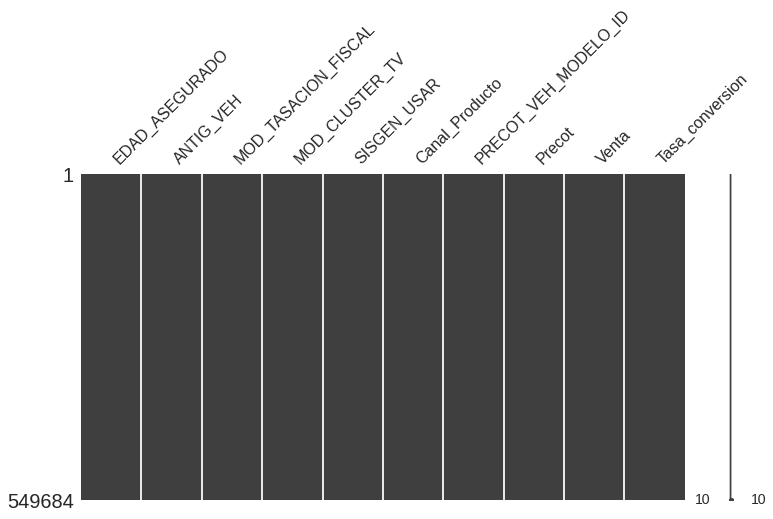

In [17]:
# Analisis de Datos Perdidos
msno.matrix(data, figsize=(12,6));

### Ajuste de Variables

In [18]:
data['ANTIG_VEH'] = data['ANTIG_VEH'].astype(int)

data['EDAD_ASEGURADO'] = np.where(data['EDAD_ASEGURADO']=='Empresa', -1, data['EDAD_ASEGURADO'])
data['EDAD_ASEGURADO'] = data['EDAD_ASEGURADO'].astype(int)

## Análisis Univariado Gráfico

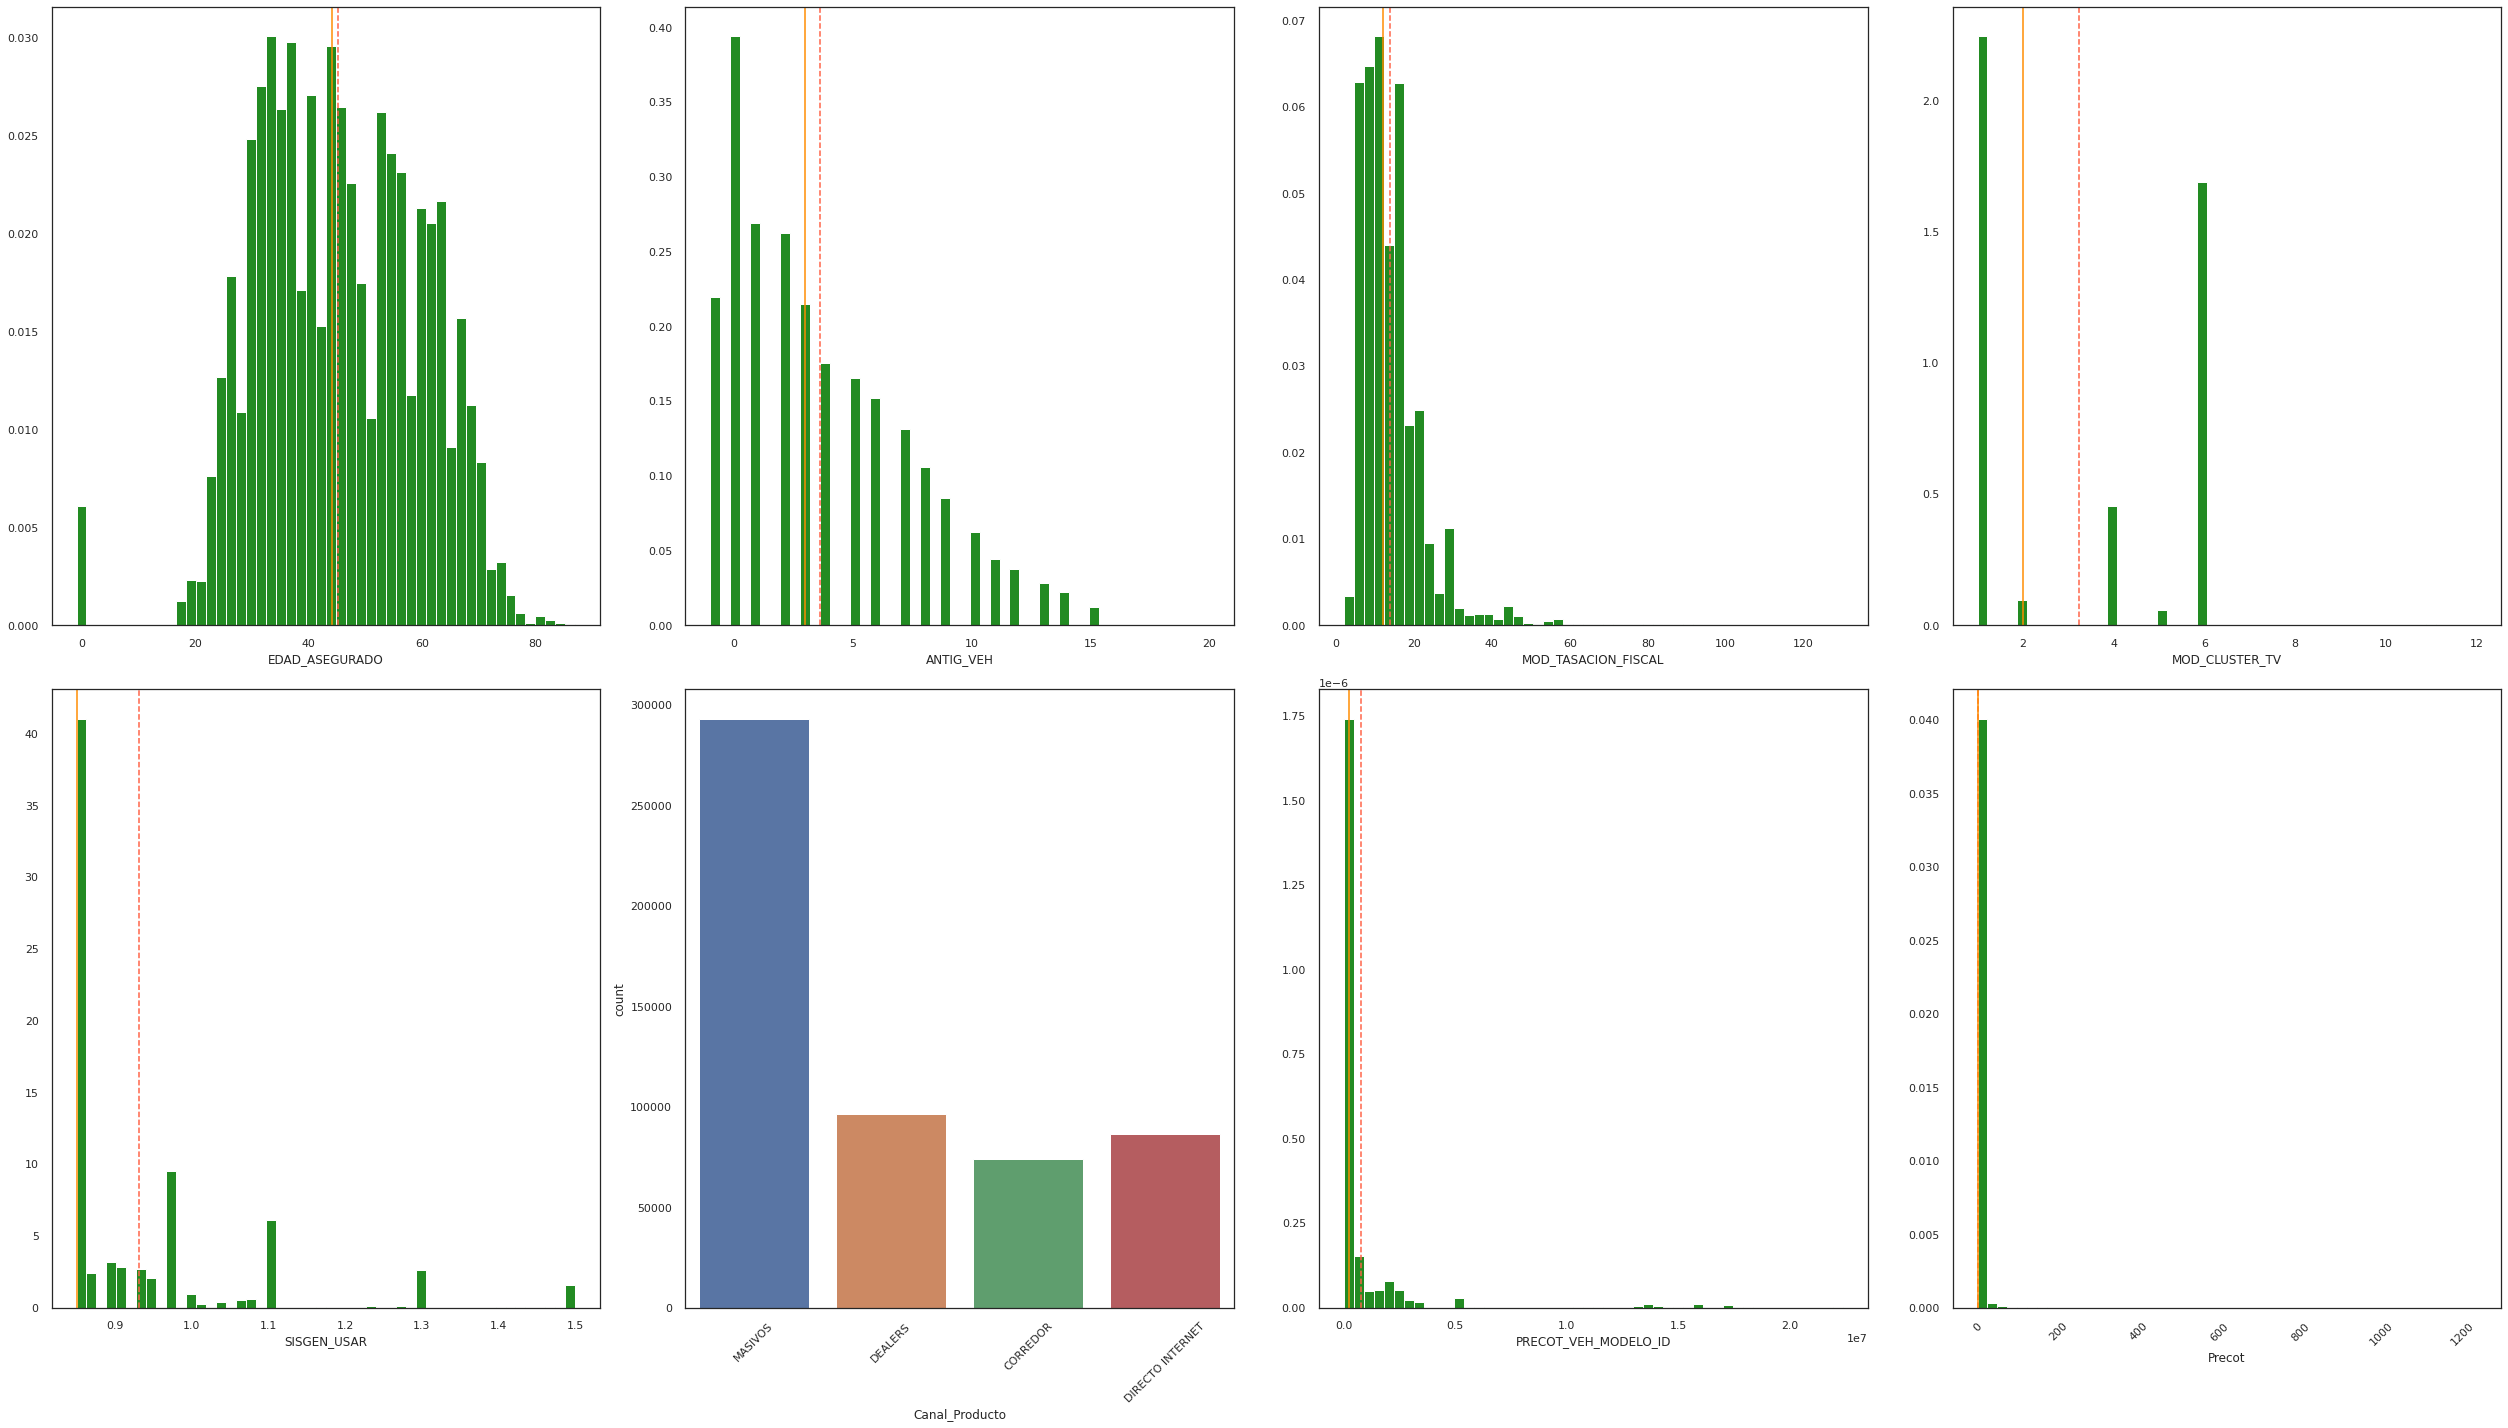

In [166]:
# Analisis Univariado
variables = ['EDAD_ASEGURADO', 'ANTIG_VEH', 'MOD_TASACION_FISCAL', 'MOD_CLUSTER_TV',
             'SISGEN_USAR', 'Canal_Producto', 'PRECOT_VEH_MODELO_ID', 'Precot']
df = data.copy()

univariate_plot(df, variables, 2, 4)

# KMeans Clustering

- Implementación de Clustering con Algoritmo KMeans para cada Canal. 
- Busqueda de K optimo.
- Ajuste y Predicción.

---

Proceso de Calculo de Clustering (K Optimo) para Canal  MASIVOS


---

Dimensiones data  MASIVOS :  (293162, 5)
Número Óptimo de Clusters (K):  5


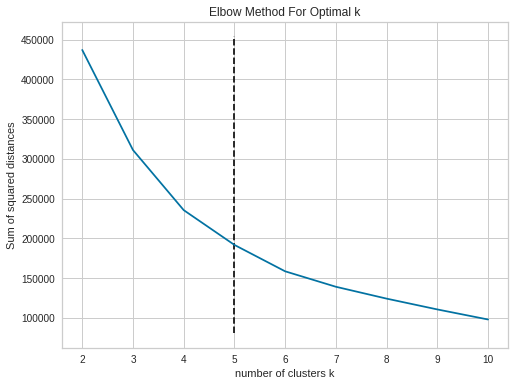

Clusters List:  [0 1 2 3 4]


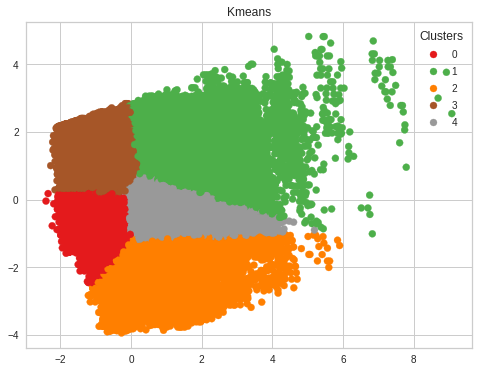

---

Proceso de Calculo de Clustering (K Optimo) para Canal  DEALERS


---

Dimensiones data  DEALERS :  (96101, 5)
Número Óptimo de Clusters (K):  5


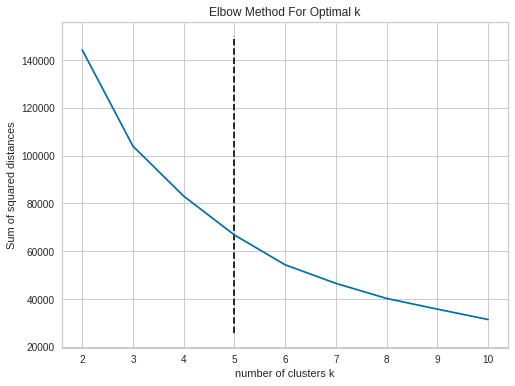

Clusters List:  [0 1 2 3 4]


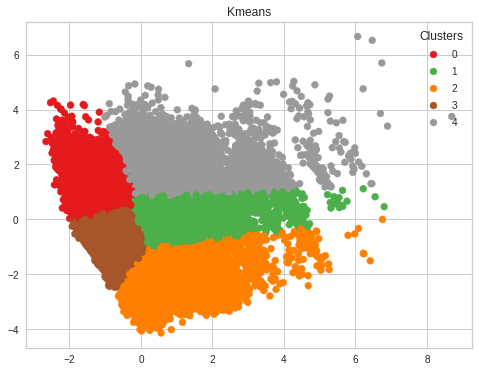

---

Proceso de Calculo de Clustering (K Optimo) para Canal  CORREDOR


---

Dimensiones data  CORREDOR :  (73818, 5)
Número Óptimo de Clusters (K):  4


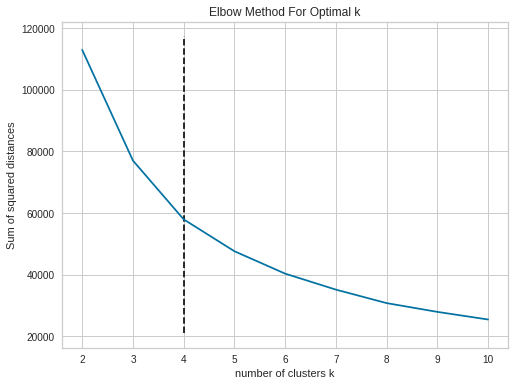

Clusters List:  [0 1 2 3]


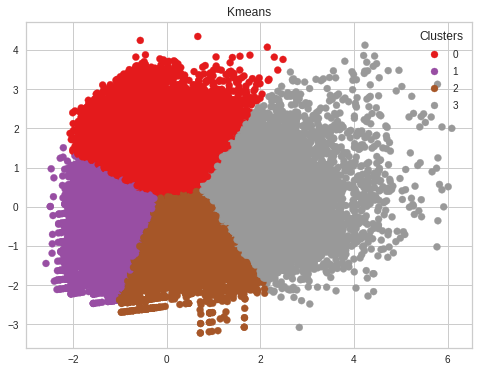

---

Proceso de Calculo de Clustering (K Optimo) para Canal  DIRECTO INTERNET


---

Dimensiones data  DIRECTO INTERNET :  (86603, 5)
Número Óptimo de Clusters (K):  5


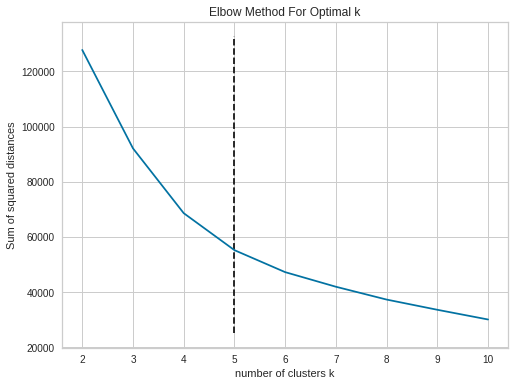

Clusters List:  [0 1 2 3 4]


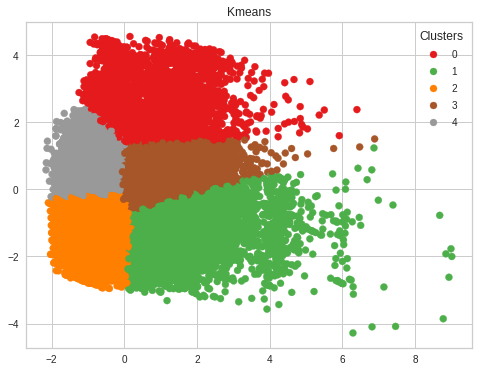

In [91]:
df_canales = list()
k_opts = list()
predicts = list()

for index, canal in enumerate(canales):

    display(Markdown('---'))
    print('Proceso de Calculo de Clustering (K Optimo) para Canal ', canal)
    display(Markdown('---'))

    # Filtro de datos por canal
    df = data[data['Canal_Producto'] == canal][['EDAD_ASEGURADO', 'ANTIG_VEH', 'MOD_TASACION_FISCAL', 'MOD_CLUSTER_TV','SISGEN_USAR']]
    print('Dimensiones data ', canal, ': ', df.shape)

    # Corrplot
    #print('\n---- Analisis de Correlaciones para Canal ', canal, ' ----')
    #corr_plot(df)

    # KMeans para cada Canal
    k_opt, Y = KMeans_optimize(df)
    k_opts.append(k_opt)

    # Implementacion de KMeans
    predict = kmeans_clustering(k_opt, Y)
    predicts.append(predict)

    df['cluster'] = predict
    df_canales.append(df)

# DecisionTreeClassifier

- Implementación de DecisionTreeClassifier para cada Canal.

---

Canal  MASIVOS


---

Proceso de Modelación con DecisionTreeClasiffier


---

Dimensiones X_train data  MASIVOS :  (219871, 5)
Dimensiones X_test data  MASIVOS :  (73291, 5)
Dimensiones y_train data  MASIVOS :  (219871,)
Dimensiones y_test data  MASIVOS :  (73291,)

--- Mejores Hyperparametros obtenidos ---

{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 2}

--- Mejor Score obtenido ---

0.9902887444942186

--- Features Importances Plot Canal MASIVOS---


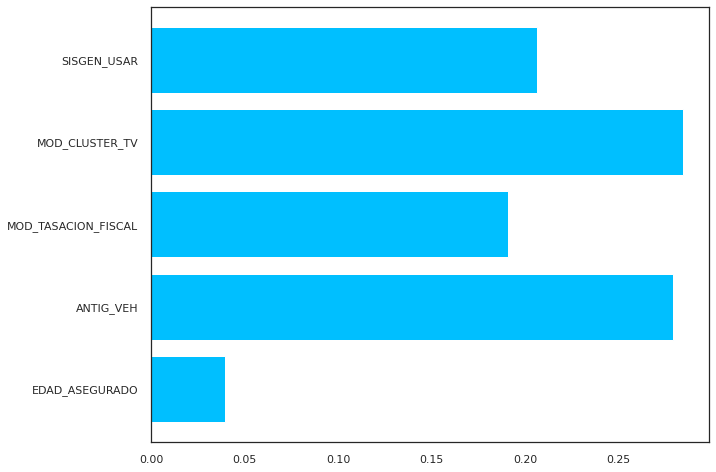


----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


--- METRICS RESUME MODEL TRAINING ---
Precision: 0.991228 
Recall: 0.991239 
F1: 0.991230

--- METRICS MODEL TRAINING ---


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.993014,0.986907,0.990589,0.993855,0.991775,0.99175,0.991228,0.991750
recall,0.996238,0.990316,0.987512,0.995741,0.986387,0.99175,0.991239,0.991750
f1-score,0.994623,0.988609,0.989048,0.994797,0.989074,0.99175,0.991230,0.991746
support,61927.000000,32425.000000,15775.000000,45318.000000,64426.000000,0.99175,219871.000000,219871.000000



 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


--- METRICS RESUME MODEL TESTING ---
Precision: 0.991364 
Recall: 0.991706 
F1: 0.991534

--- METRICS MODEL TESTING ---


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.993859,0.987281,0.9903,0.994766,0.990611,0.991868,0.991364,0.991869
recall,0.995688,0.991026,0.9903,0.994042,0.987474,0.991868,0.991706,0.991868
f1-score,0.994773,0.989150,0.9903,0.994404,0.989040,0.991868,0.991534,0.991867
support,20642.000000,10809.000000,5258.0000,15106.000000,21476.000000,0.991868,73291.000000,73291.000000



--- Comparación KMeans vs. DesicionTreeClasifier ---



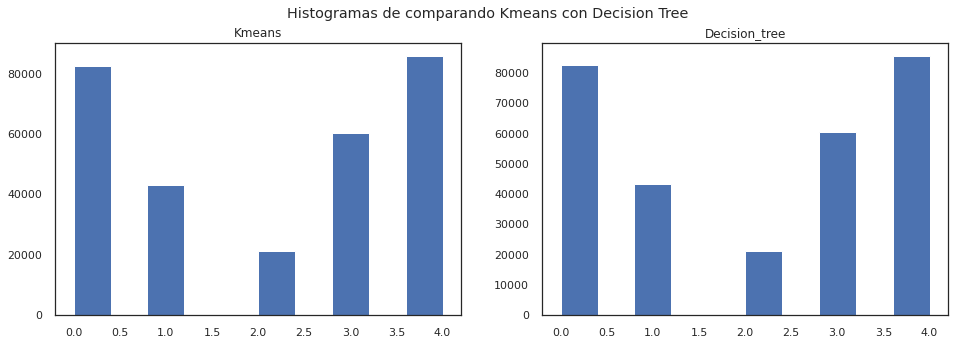




 DecisionTree Model expoted in dot png and txt format.




---

Canal  DEALERS


---

Proceso de Modelación con DecisionTreeClasiffier


---

Dimensiones X_train data  DEALERS :  (72075, 5)
Dimensiones X_test data  DEALERS :  (24026, 5)
Dimensiones y_train data  DEALERS :  (72075,)
Dimensiones y_test data  DEALERS :  (24026,)

--- Mejores Hyperparametros obtenidos ---

{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 2}

--- Mejor Score obtenido ---

0.977642793003783

--- Features Importances Plot Canal DEALERS---


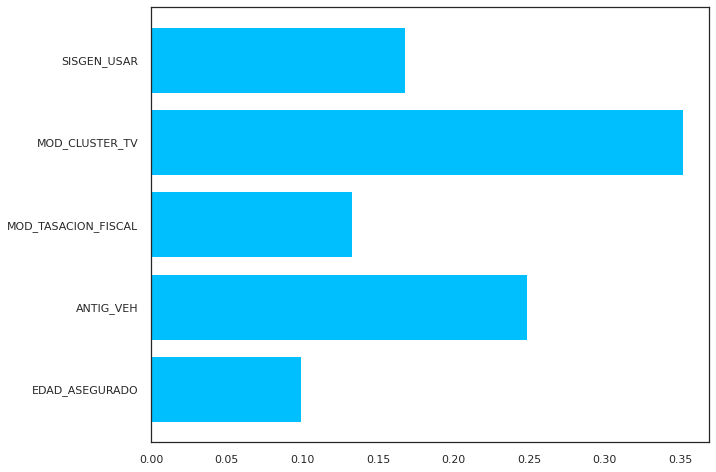


----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


--- METRICS RESUME MODEL TRAINING ---
Precision: 0.980572 
Recall: 0.978128 
F1: 0.979336

--- METRICS MODEL TRAINING ---


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.985349,0.980783,0.967003,0.993551,0.976172,0.984058,0.980572,0.984052
recall,0.989051,0.986954,0.959184,0.991070,0.964379,0.984058,0.978128,0.984058
f1-score,0.987197,0.983859,0.963078,0.992309,0.970240,0.984058,0.979336,0.984046
support,9316.000000,25908.000000,5194.000000,23628.000000,8029.000000,0.984058,72075.000000,72075.000000



 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


--- METRICS RESUME MODEL TESTING ---
Precision: 0.981310 
Recall: 0.978210 
F1: 0.979733

--- METRICS MODEL TESTING ---


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.980211,0.981833,0.970743,0.995034,0.978731,0.984808,0.981310,0.984806
recall,0.988731,0.988653,0.958406,0.992255,0.963004,0.984808,0.978210,0.984808
f1-score,0.984453,0.985231,0.964535,0.993643,0.970804,0.984808,0.979733,0.984790
support,3106.000000,8637.000000,1731.000000,7876.000000,2676.000000,0.984808,24026.000000,24026.000000



--- Comparación KMeans vs. DesicionTreeClasifier ---



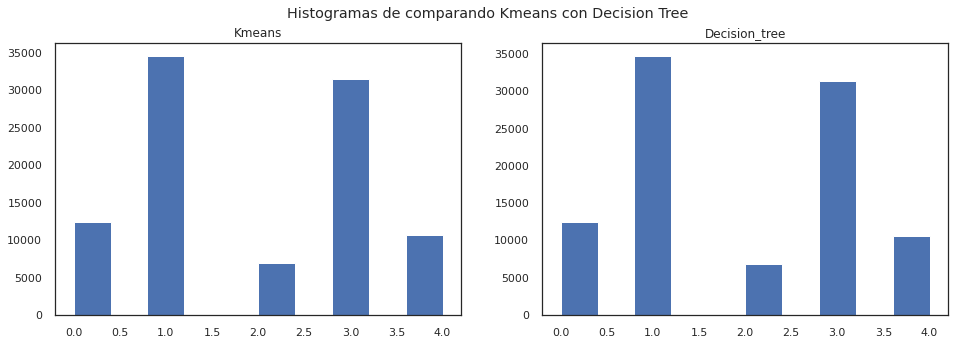




 DecisionTree Model expoted in dot png and txt format.




---

Canal  CORREDOR


---

Proceso de Modelación con DecisionTreeClasiffier


---

Dimensiones X_train data  CORREDOR :  (55363, 5)
Dimensiones X_test data  CORREDOR :  (18455, 5)
Dimensiones y_train data  CORREDOR :  (55363,)
Dimensiones y_test data  CORREDOR :  (18455,)

--- Mejores Hyperparametros obtenidos ---

{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5}

--- Mejor Score obtenido ---

0.9603919759551551

--- Features Importances Plot Canal CORREDOR---


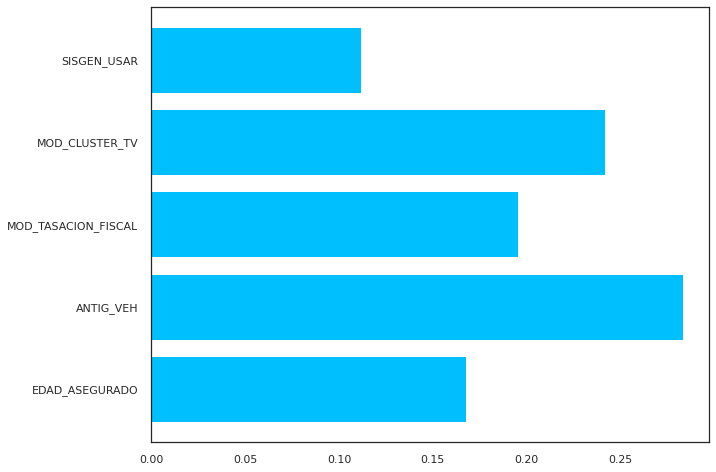


----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


--- METRICS RESUME MODEL TRAINING ---
Precision: 0.964618 
Recall: 0.962011 
F1: 0.963264

--- METRICS MODEL TRAINING ---


,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.968169,0.975913,0.965342,0.949048,0.966801,0.964618,0.966719
recall,0.978344,0.980391,0.965494,0.923814,0.966801,0.962011,0.966801
f1-score,0.973230,0.978147,0.965418,0.936261,0.966801,0.963264,0.966728
support,12560.000000,15911.000000,19069.000000,7823.000000,0.966801,55363.000000,55363.000000



 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


--- METRICS RESUME MODEL TESTING ---
Precision: 0.961785 
Recall: 0.960468 
F1: 0.961104

--- METRICS MODEL TESTING ---


,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.965501,0.976617,0.964280,0.940741,0.964833,0.961785,0.964777
recall,0.975878,0.976433,0.963977,0.925585,0.964833,0.960468,0.964833
f1-score,0.970662,0.976525,0.964128,0.933101,0.964833,0.961104,0.964790
support,4187.000000,5304.000000,6357.000000,2607.000000,0.964833,18455.000000,18455.000000



--- Comparación KMeans vs. DesicionTreeClasifier ---



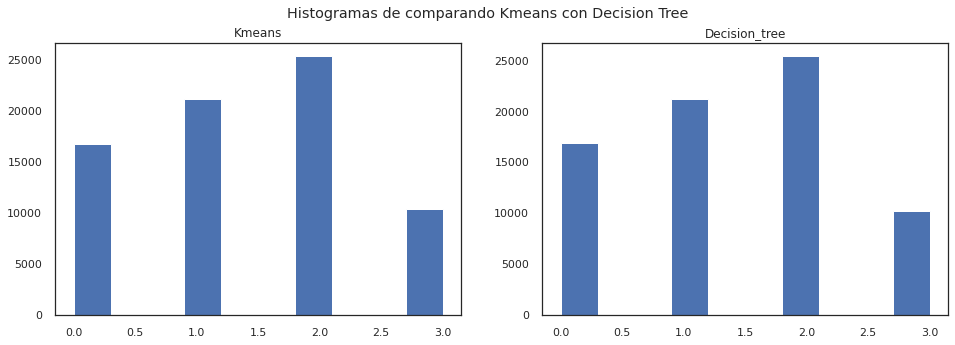




 DecisionTree Model expoted in dot png and txt format.




---

Canal  DIRECTO INTERNET


---

Proceso de Modelación con DecisionTreeClasiffier


---

Dimensiones X_train data  DIRECTO INTERNET :  (64952, 5)
Dimensiones X_test data  DIRECTO INTERNET :  (21651, 5)
Dimensiones y_train data  DIRECTO INTERNET :  (64952,)
Dimensiones y_test data  DIRECTO INTERNET :  (21651,)

--- Mejores Hyperparametros obtenidos ---

{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5}

--- Mejor Score obtenido ---

0.9772985328355391

--- Features Importances Plot Canal DIRECTO INTERNET---


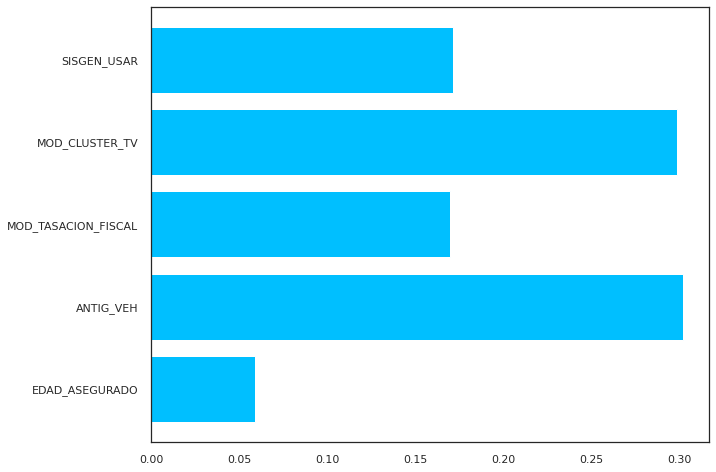


----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


--- METRICS RESUME MODEL TRAINING ---
Precision: 0.977282 
Recall: 0.980067 
F1: 0.978661

--- METRICS MODEL TRAINING ---


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.960315,0.972589,0.985374,0.978890,0.989245,0.981294,0.977282,0.981315
recall,0.973957,0.977931,0.988293,0.972751,0.987405,0.981294,0.980067,0.981294
f1-score,0.967088,0.975253,0.986831,0.975811,0.988324,0.981294,0.978661,0.981297
support,3379.000000,10558.000000,14179.000000,18019.000000,18817.000000,0.981294,64952.000000,64952.000000



 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


--- METRICS RESUME MODEL TESTING ---
Precision: 0.979666 
Recall: 0.981560 
F1: 0.980607

--- METRICS MODEL TESTING ---


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.964820,0.976764,0.987558,0.978777,0.990414,0.983003,0.979666,0.983012
recall,0.974245,0.979261,0.990901,0.975029,0.988361,0.983003,0.981560,0.983003
f1-score,0.969510,0.978011,0.989227,0.976899,0.989386,0.983003,0.980607,0.983004
support,1126.000000,3520.000000,4726.000000,6007.000000,6272.000000,0.983003,21651.000000,21651.000000



--- Comparación KMeans vs. DesicionTreeClasifier ---



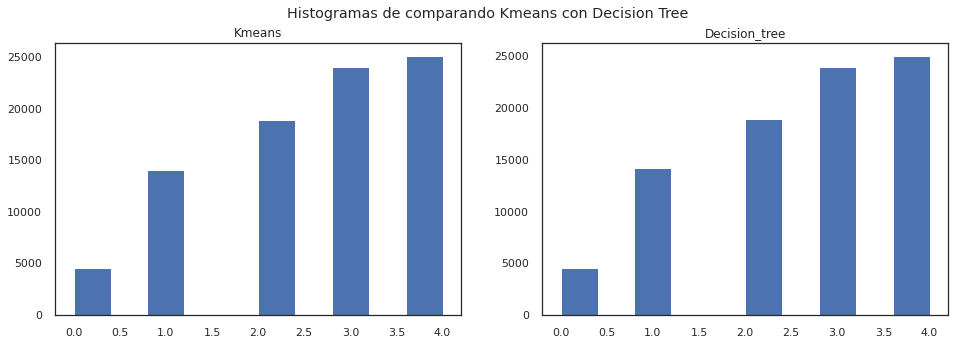




 DecisionTree Model expoted in dot png and txt format.




In [164]:
x_train_list = list()
x_test_list = list()
y_train_list = list()
y_test_list = list()
model_list = list()
y_train_pred_list = list()
y_train_proba_list = list()
y_test_pred_list = list()
y_test_proba_list = list()

for index, canal in enumerate(canales):

    display(Markdown('---'))
    print('Canal ', canal)
    display(Markdown('---'))
    print('Proceso de Modelación con DecisionTreeClasiffier')
    display(Markdown('---'))

    X = df_canales[index].drop(columns = ['cluster'], axis = 1)
    Y = df_canales[index]['cluster']

    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 16626, shuffle = True, stratify = Y)

    print('Dimensiones X_train data ', canal, ': ', X_train.shape)
    print('Dimensiones X_test data ', canal, ': ', X_test.shape)
    print('Dimensiones y_train data ', canal, ': ', y_train.shape)
    print('Dimensiones y_test data ', canal, ': ', y_test.shape)

    x_train_list.append(X_train)
    x_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    # Busqueda de grilla de hyperparametros
    params = tree_hyperparameters_tuning(X_train, y_train)

    print('\n--- Mejores Hyperparametros obtenidos ---\n')
    print(params.best_params_)
    print('\n--- Mejor Score obtenido ---\n')
    print(params.best_score_)

    model, y_train_pred, y_train_proba, y_test_pred, y_test_proba = fit_model_tree(X_train, y_train, X_test, params)

    model_list.append(model)
    y_train_pred_list.append(y_train_pred)
    y_train_proba_list.append(y_train_proba[:, 1])
    y_test_pred_list.append(y_test_pred)
    y_test_proba_list.append(y_test_proba[:, 1])

    print('\n--- Features Importances Plot Canal {}---'.format(canal))
    features_list = X_train.columns
    features_importances_plot(model, features_list)

    print('\n----------------------------------------------------------------------------')
    print('Metrics Report Model ' + model.__class__.__name__ + ' -- Training Dataset')
    print('---------------------------------------------------------------------------- \n')

    # metrics
    print("\n--- METRICS RESUME MODEL TRAINING ---")
    print("Precision: %f "%precision_score(y_train, y_train_pred, average='macro'))
    print("Recall: %f "%recall_score(y_train, y_train_pred, average='macro'))
    print("F1: %f"% f1_score(y_train, y_train_pred, average='macro')) 

    # Metrics Resume
    print("\n--- METRICS MODEL TRAINING ---")
    display(pd.DataFrame(classification_report(y_train, y_train_pred, output_dict = True)))

    print('\n \n ----------------------------------------------------------------------------')
    print('Metrics Report Model ' + model.__class__.__name__ + ' -- Testing Dataset')
    print('---------------------------------------------------------------------------- \n')

    # metrics
    print("\n--- METRICS RESUME MODEL TESTING ---")
    print("Precision: %f "%precision_score(y_test, y_test_pred, average='macro'))
    print("Recall: %f "%recall_score(y_test, y_test_pred, average='macro'))
    print("F1: %f"% f1_score(y_test, y_test_pred, average='macro'))

    # Metrics Resume
    print("\n--- METRICS MODEL TESTING ---")
    display(pd.DataFrame(classification_report(y_test, y_test_pred, output_dict = True)))

    print('\n--- Comparación KMeans vs. DesicionTreeClasifier ---\n')
    df_canales[index]['tree_predict'] = model.predict(X)
    
    fig , (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
    fig.suptitle('Histogramas de comparando Kmeans con Decision Tree')
    ax1.set_title('Kmeans')
    ax1.hist(df_canales[index]['cluster'])
    ax2.set_title('Decision_tree')
    ax2.hist(df_canales[index]['tree_predict'])
    plt.show();

    print("\n")
    tree_export(canal, X_train, model)

    print("\n")

In [163]:
]# Copia del Carpeta de Trabajo a Drive
!cp -r /tmp/data_clustering /gdrive/My\ Drive/Clustering_profile_HDI